In [1]:
from IPython.core.display import HTML
import requests
import re

import matplotlib.pylab as plt
from astropy import units as u

In [108]:
# WebPIMMS request, deduced from web application requests

def webpimms_flux(e1: float, e2: float, slope: float=2):
    t = requests.post("https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3pimms/w3pimms.pl",
                  data={
                      "from": "INTEGRAL/ISGRI Count Rate",
                      "sat": "FLUX",
                      "range": f"{e1}-{e2}",
                      "etype": "kev",
                      "orange": f"{e1}-{e2}",
                      "otype": "kev",
                      "flusso": 1,
                      "nh": 0,
                      "red": "none",
                      "nhi": "none",
                      "model": "Power Law",
                      "gama": slope,
                      "solar": "1.0 Solar Abundance",
                  }
                 ).text      

    return float(re.search("PIMMS predicts a flux .*? of (.*?) ergs/cm/cm/s", t).groups()[0])

#HTML(t)


webpimms_flux(20, 40, 3)

4.39e-11

In [3]:
# query crab spectra and responses

from astroquery.simbad import Simbad
import numpy as np
from astropy.coordinates import SkyCoord

result_table = Simbad.query_object("Crab")

c = SkyCoord(result_table['RA'][0], result_table['DEC'][0], unit=("hourangle", "deg"))



from oda_api.api import DispatcherAPI

products_for_src = lambda o, name: { 
        v.meta_data['product']:v 
            for k,v in o.__dict__.items() 
            if getattr(v,'meta_data',{}).get('src_name') == name
    }



disp=DispatcherAPI(host="https://www.astro.unige.ch/cdci/astrooda/dispatch-data")

T1_2osa_utc="2016-01-01T00:00:00"
T2_2osa_utc="2017-01-01T00:00:00"


spec_data_osa10=disp.get_product(instrument='isgri',
                    product='isgri_spectrum',
                    T1=T1_2osa_utc,
                    T2=T2_2osa_utc,
                    query_type='Real',
                    osa_version='OSA10.2',
                    RA=c.ra.deg,
                    DEC=c.dec.deg,
                    product_type='Real',
                    #selected_catalog=api_cat
                    )

spec_data_osa11=disp.get_product(instrument='isgri',
                    product='isgri_spectrum',
                    T1=T1_2osa_utc,
                    T2=T2_2osa_utc,
                    query_type='Real',
                    osa_version='OSA11.0',
                    RA=c.ra.deg,
                    DEC=c.dec.deg,
                    product_type='Real',
                    #selected_catalog=api_cat,
                    )



- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2016-01-01T00:00:00
T2 2017-01-01T00:00:00
query_type Real
osa_version OSA10.2
RA 83.63308333333332
DEC 22.0145
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbose (False,)
session_id NKTHPIK113UMVHOV
dry_run (False,)
api True
oda_api_version 1.0.2
the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=-8431756989072857662  662 

query done succesfully!
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2016-01-01T00:00:00
T2 2017-01-01T00:00:00
query_type Real
osa_version OSA11.0
RA 83.63308333333332
DEC 22.0145
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbose (False,)
session_id XSN549KGTK0XWWAU
dry_run (False,)
api True
oda_api_version 1.0.2
the job has been submitted 

--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
flux_eband 7.496672168974315e-09
response norm in 20 40 is 144.07974 rate norm 136.2734 erg/cm2 per count 5.203141012367613e-11
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
flux_eband 1.0978330689697354e-10
response norm in 20 40 is 2.1093228 rate norm 136.2734 erg/cm2 per count 5.204670788576826e-11
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
flux_eband 5.847078588199936e-11
response norm in 20 40 is 1.1092813 rate norm 136.2734 erg/cm2 per count 5.271051247597632e-11
--> NAME PRIMARY
--> NAME EBOUNDS
--> NAME SPECRESP MATRIX
--> NAME PRIMARY
--> NAME EBOUNDS
--> NAME SPECRESP MATRIX
flux_eband 6.791912992448839e-09
re

<ipython-input-183-acfc7d86e87f>:90: RuntimeWarning: invalid value encountered in double_scalars
  erg_cm2_per_count = flux_erg_cm2_s_eband/n


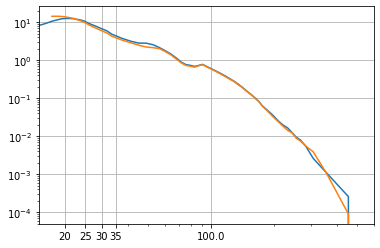

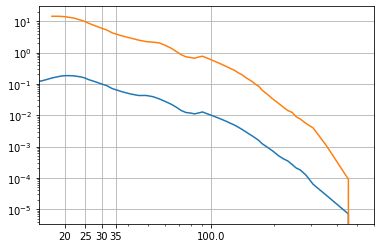

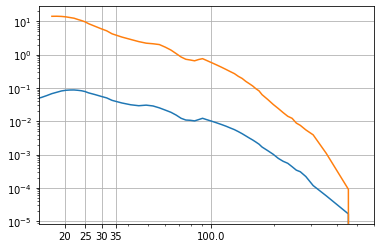

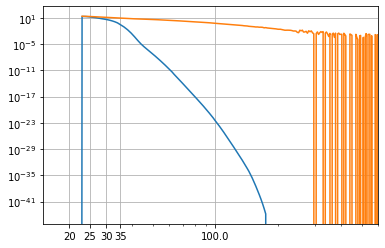

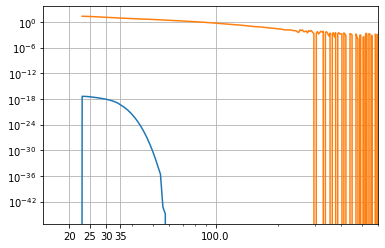

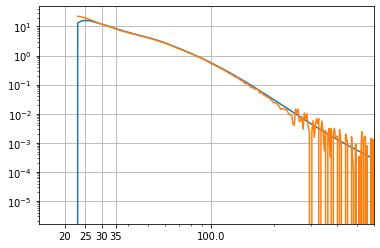

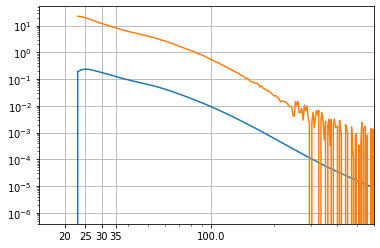

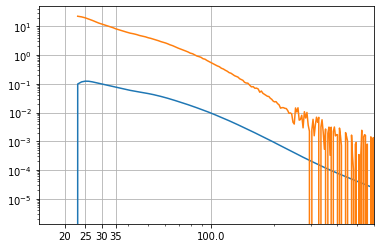

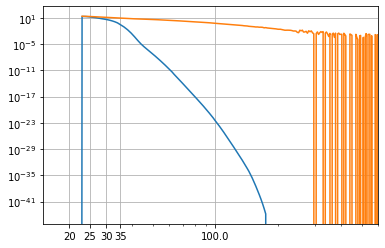

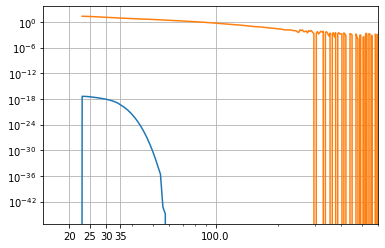

In [183]:
def extra_ticks(et):
    ax = plt.gca()
    tx = ax.get_xticks()
    ax.set_xticks(
        list(tx)+et
    )
    ax.set_xticklabels(
        list(tx)+et
    )

    
    

# Roques & Jourdain 2018
def crab_ph_cm2_s_kev(en):
    K=7.417e-4
    al1=-1.98
    al2=-2.33
    Ec=500.
    f=K*(en/100)**al1*(np.exp(-en/Ec))
    m=en>Ec*(al1-al2)
    f[m]=(K*((al1-al2)*Ec/100)**(al1-al2)*(en/100)**al2*np.exp(-(al1-al2)))[m]

    return f

def powerlaw_ph_cm2_s_kev(en, slope):
    K=1e-5
    f=K*(en/100)**slope
    
    return f

def he_bb_ph_cm2_s_kev(en, T_keV):
    K=1e10
    f=K*(en/100)**3*np.exp(-en/T_keV)
    
    return f


def resp_norm(D, e1, e2, plot=False, model="crab"):
    p = products_for_src(D, 'Crab')
    
    arf=p['isgri_arf'].data_unit[1].data
    rmf_eb=p['isgri_rmf'].get_data_unit_by_name('EBOUNDS').data
    rmf_mt=p['isgri_rmf'].get_data_unit_by_name('SPECRESP MATRIX').data
    spec=p['isgri_spectrum'].data_unit[1]
    
    crab_ph_cm2_s_kev    
    ie1=arf['ENERG_LO']
    ie2=arf['ENERG_HI']
    
    if model == "crab":
        source=crab_ph_cm2_s_kev(ie1)
    else:
        source = model(ie1)
    
    m_flux = (ie1>e1) & (ie2<=e2)
    flux_erg_cm2_s_eband = np.nansum((source*(ie2-ie1)*ie1)[m_flux])*((1.*u.keV).to(u.erg).value)
    
    print("flux_eband", flux_erg_cm2_s_eband)
    
    
    csource=np.outer(arf['SPECRESP']*source*(ie2-ie1),np.ones_like(rmf_eb['E_MIN']))*rmf_mt['MATRIX']
        
    
    if plot:
        plt.figure()
        plt.plot(
            rmf_eb['E_MIN'],
            csource.sum(0)/(rmf_eb['E_MAX']-rmf_eb['E_MIN'])
        )
        
        plt.plot(
            rmf_eb['E_MIN'],
            spec.data['RATE']/(rmf_eb['E_MAX']-rmf_eb['E_MIN'])
        )
        
        plt.loglog()
        
        extra_ticks(
            [20,25,30,35]
        )
        
        plt.xlim([15, 600])
        plt.grid()

    rate_n = np.nansum(spec.data['RATE'][(rmf_eb['E_MIN']>e1) & (rmf_eb['E_MAX']<e2)])

    n = csource[:,(rmf_eb['E_MIN']>e1) & (rmf_eb['E_MAX']<e2)].sum()
    
    erg_cm2_per_count = flux_erg_cm2_s_eband/n
    
    print("response norm in", e1,e2,"is",n, "rate norm", rate_n, "erg/cm2 per count", erg_cm2_per_count)

    return erg_cm2_per_count


erg_cm2_per_count = []
    
plot=True
for e1,e2 in [
    (20, 40),
    (40, 60),
    (60, 100),
]:
    for origin, c in [
        ('osa10_pl2', resp_norm(spec_data_osa10, e1, e2, plot=plot)),
        ('osa10_pl3.5', resp_norm(spec_data_osa10, e1, e2, plot=plot, model=lambda x: powerlaw_ph_cm2_s_kev(x, -2))),
        ('osa10_pl1.5', resp_norm(spec_data_osa10, e1, e2, plot=plot, model=lambda x: powerlaw_ph_cm2_s_kev(x, -1.5))),        
        ('osa10_bb1k', resp_norm(spec_data_osa11, e1, e2, plot=plot, model=lambda x: he_bb_ph_cm2_s_kev(x, 1))),  
        ('osa10_bb03k', resp_norm(spec_data_osa11, e1, e2, plot=plot, model=lambda x: he_bb_ph_cm2_s_kev(x, 0.3))),
        ('osa11_pl2', resp_norm(spec_data_osa11, e1, e2, plot=plot)),
        ('osa11_pl3.5', resp_norm(spec_data_osa11, e1, e2, plot=plot, model=lambda x: powerlaw_ph_cm2_s_kev(x, -2))),
        ('osa11_pl1.5', resp_norm(spec_data_osa11, e1, e2, plot=plot, model=lambda x: powerlaw_ph_cm2_s_kev(x, -1.5))),        
        ('osa11_bb1k', resp_norm(spec_data_osa11, e1, e2, plot=plot, model=lambda x: he_bb_ph_cm2_s_kev(x, 1))),  
        ('osa11_bb03k', resp_norm(spec_data_osa11, e1, e2, plot=plot, model=lambda x: he_bb_ph_cm2_s_kev(x, 0.3))),  
        ('pimms_pl2', webpimms_flux(e1,e2)),
        ('pimms_pl1.5', webpimms_flux(e1,e2,1.5)),
        ('pimms_pl3.5', webpimms_flux(e1,e2,3.5)),
    ]:    
        erg_cm2_per_count.append(dict(
            e1=e1,
            e2=e2,
            origin=origin,
            erg_cm2_in_count=c,
        ))
    
    plot=False


In [186]:
import json

json.dump(
    erg_cm2_per_count,
    open("conversions.json", "wt")
)

!cat conversions.json | jq

[
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa10_pl2",
    "erg_cm2_in_count": 5.203141012367613e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa10_pl3.5",
    "erg_cm2_in_count": 5.204670788576826e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa10_pl1.5",
    "erg_cm2_in_count": 5.271051247597632e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa10_bb1k",
    "erg_cm2_in_count": 6.663389871058146e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa10_bb03k",
    "erg_cm2_in_count": 4.62678438487648e-13
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa11_pl2",
    "erg_cm2_in_count": 3.965625891795422e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa11_pl3.5",
    "erg_cm2_in_count": 3.947101201101499e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa11_pl1.5",
    "erg_cm2_in_count": 3.759987598388854e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa11_bb1k",
    "erg_cm2_in_count": 6.663389871058146e-11
  

In [185]:
import pandas as pd

rdiff_pc = lambda x,ax: (100*(ax-x)/ax)

print(f"\033[34m     {'key':20s} {'value':10s} ", end="")
for ref in 'osa10_pl2', 'osa11_pl2', 'pimms_pl2':
    print(f" \033[34m{'vs-'+ref:15s}\033[0m", end="")
print()

for (e1,e2), v in pd.DataFrame(erg_cm2_per_count).groupby(['e1', 'e2']):
    bo = dict(list(v.groupby('origin')))
    bo = {**bo, **hilight_rdata}
    print(f"\033[32m{e1:3d} {e2:3d}\033[0m") 
    for k, v in bo.items():
        try:
            c = v.erg_cm2_in_count.iloc[0]
        except:
            c = v[(e1,e2)]

        print(f"    {k:20s} {c:9.2e}", end="")
            
        for ref in 'osa10_pl2', 'osa11_pl2', 'pimms_pl2':
            dc = rdiff_pc(c, bo[ref].erg_cm2_in_count.iloc[0])

            if abs(dc)>50:
                C = '\033[31m'        
            elif abs(dc)>30:
                C = '\033[33m'
            else:
                C = '\033[32m'
        
            print(f"{C}{dc:15.0f}%\033[0m", end="")
        print(f"")
          

     key                  value       vs-osa10_pl2    vs-osa11_pl2    vs-pimms_pl2   
 20  40
    osa10_bb03k           4.63e-13             99%             99%             99%
    osa10_bb1k            6.66e-11            -28%            -68%            -59%
    osa10_pl1.5           5.27e-11             -1%            -33%            -25%
    osa10_pl2             5.20e-11              0%            -31%            -24%
    osa10_pl3.5           5.20e-11             -0%            -31%            -24%
    osa11_bb03k           4.63e-13             99%             99%             99%
    osa11_bb1k            6.66e-11            -28%            -68%            -59%
    osa11_pl1.5           3.76e-11             28%              5%             11%
    osa11_pl2             3.97e-11             24%              0%              6%
    osa11_pl3.5           3.95e-11             24%              0%              6%
    pimms_pl1.5           4.13e-11             21%             -4%          

In [123]:

#
# === INTEGRAL ===========================================
#
# Only calculated for plaw and no absorption.
# (Mission, Model, Spectral Index) : (20-40keV, 40-60keV, 60-100keV)

hilight_eband_index=((20,40), (40,60), (60,100))

hilight_data={
    # ('Integral','plaw',0.5): MISSING
    # ('Integral','plaw',1.0): MISSING
    ('Integral','plaw',1.5):(5.959E-11,1.411E-11,2.237E-11),
    # ('Integral','plaw',1.7): MISSING
    ('Integral','plaw',2.0):(1.844E-11,1.290E-11,1.624E-11),
    ('Integral','plaw',2.5):(2.583E-11,1.068E-11,1.116E-11),
    ('Integral','plaw',3.0):(2.024E-11,0.836E-11,0.634E-11),
    ('Integral','plaw',3.5):(1.115E-11,0.373E-11,0.361E-11),

    ('Integral','bbody',0.06):(1.844E-11,1.290E-11,1.624E-11),
    ('Integral','bbody',0.1):(1.844E-11,1.290E-11,1.624E-11),
    ('Integral','bbody',0.3):(1.844E-11,1.290E-11,1.624E-11),
    ('Integral','bbody',1.0):(1.844E-11,1.290E-11,1.624E-11),
}

hilight_rdata = {}

for ik, v in hilight_data.items():
    D={}
    hilight_rdata[f"hili_{ik[1]}_{ik[2]:2g}"] = D
    for (e1,e2), v in zip(hilight_eband_index, hilight_data[ik]):
        print(e1,e2,ik,v)
        D[(e1,e2)]=v

20 40 ('Integral', 'plaw', 1.5) 5.959e-11
40 60 ('Integral', 'plaw', 1.5) 1.411e-11
60 100 ('Integral', 'plaw', 1.5) 2.237e-11
20 40 ('Integral', 'plaw', 2.0) 1.844e-11
40 60 ('Integral', 'plaw', 2.0) 1.29e-11
60 100 ('Integral', 'plaw', 2.0) 1.624e-11
20 40 ('Integral', 'plaw', 2.5) 2.583e-11
40 60 ('Integral', 'plaw', 2.5) 1.068e-11
60 100 ('Integral', 'plaw', 2.5) 1.116e-11
20 40 ('Integral', 'plaw', 3.0) 2.024e-11
40 60 ('Integral', 'plaw', 3.0) 8.36e-12
60 100 ('Integral', 'plaw', 3.0) 6.34e-12
20 40 ('Integral', 'plaw', 3.5) 1.115e-11
40 60 ('Integral', 'plaw', 3.5) 3.73e-12
60 100 ('Integral', 'plaw', 3.5) 3.61e-12
20 40 ('Integral', 'bbody', 0.06) 1.844e-11
40 60 ('Integral', 'bbody', 0.06) 1.29e-11
60 100 ('Integral', 'bbody', 0.06) 1.624e-11
20 40 ('Integral', 'bbody', 0.1) 1.844e-11
40 60 ('Integral', 'bbody', 0.1) 1.29e-11
60 100 ('Integral', 'bbody', 0.1) 1.624e-11
20 40 ('Integral', 'bbody', 0.3) 1.844e-11
40 60 ('Integral', 'bbody', 0.3) 1.29e-11
60 100 ('Integral', 'bbo